In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import plotly.express as ex

# Goodness of fit

In [40]:
import numpy as np
from scipy import stats
rng = np.random.default_rng()
x = stats.uniform.rvs(size=75, random_state=rng)

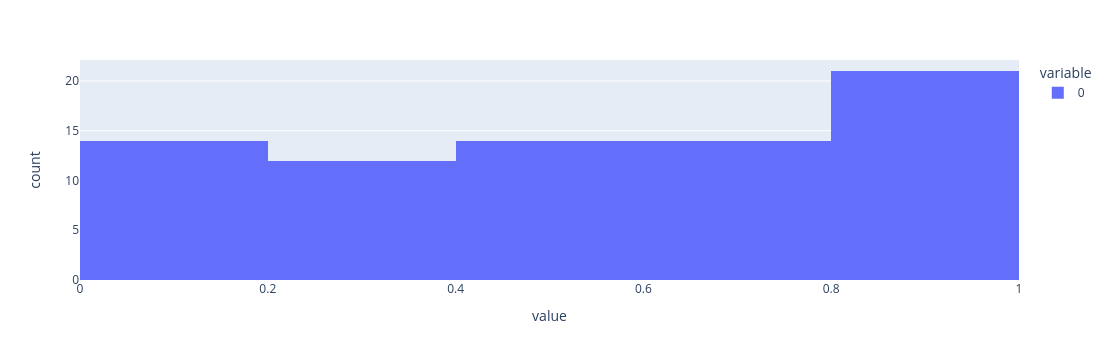

In [34]:
ex.histogram(x)

In [35]:
loc, scale = np.mean(x), np.std(x, ddof=1)
loc, scale

(0.5373675168571563, 0.3018575007187901)

In [36]:
cdf = stats.norm(loc, scale).cdf
stats.ks_1samp(x, cdf)

KstestResult(statistic=0.1148076222013018, pvalue=0.25599061726604483, statistic_location=0.696943112447806, statistic_sign=-1)

In [37]:
known_params = {'loc': loc, 'scale': scale}
res = stats.goodness_of_fit(stats.norm, x, known_params=known_params,
                            statistic='ks', random_state=rng)
res.statistic, res.pvalue

(0.1148076222013018, 0.2576)

In [38]:
res = stats.goodness_of_fit(stats.norm, x, statistic='ks',
                            random_state=rng)
res.statistic, res.pvalue

(0.1148076222013018, 0.0155)

In [39]:
res = stats.goodness_of_fit(stats.norm, x, statistic='ad',
                            random_state=rng)
res.statistic, res.pvalue

(1.52602735302861, 0.0006)

# Multivariate normal

In [55]:
x = np.random.multivariate_normal(np.zeros(3), np.diag([3, 7, 10]), 1000000)

In [56]:
np.mean(x, axis=0)

array([ 0.00209866, -0.00019803, -0.00011677])

In [57]:
np.cov(x.T)

array([[ 3.00378362e+00, -6.68835427e-03,  6.83265862e-03],
       [-6.68835427e-03,  7.01549690e+00, -7.96303201e-03],
       [ 6.83265862e-03, -7.96303201e-03,  9.99773493e+00]])

# Other

In [1]:
from tracking.target import ConstantVelocityTarget
from tracking.kalman import kalman_pv
from tracking.motion import ConstantVelocityModel

In [2]:
t = ConstantVelocityTarget()
t.true_states(1, 10)

array([[  0.,   0.,   0.,  30.,   0.,   0.],
       [ 30.,   0.,   0.,  30.,   0.,   0.],
       [ 60.,   0.,   0.,  30.,   0.,   0.],
       [ 90.,   0.,   0.,  30.,   0.,   0.],
       [120.,   0.,   0.,  30.,   0.,   0.],
       [150.,   0.,   0.,  30.,   0.,   0.],
       [180.,   0.,   0.,  30.,   0.,   0.],
       [210.,   0.,   0.,  30.,   0.,   0.],
       [240.,   0.,   0.,  30.,   0.,   0.],
       [270.,   0.,   0.,  30.,   0.,   0.]])

In [3]:
kf = kalman_pv(ConstantVelocityModel(), 1)

In [4]:
kf.predict(1)

In [24]:
kf.update(np.array([1, 1, 1]))

In [25]:
kf.x

array([[0.92105263],
       [0.92105263],
       [0.92105263],
       [0.59210526],
       [0.59210526],
       [0.59210526]])

In [22]:
kf.x_hat

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [23]:
kf.P

array([[0.22580645, 0.        , 0.        , 0.14516129, 0.        ,
        0.        ],
       [0.        , 0.22580645, 0.        , 0.        , 0.14516129,
        0.        ],
       [0.        , 0.        , 0.22580645, 0.        , 0.        ,
        0.14516129],
       [0.14516129, 0.        , 0.        , 1.12903226, 0.        ,
        0.        ],
       [0.        , 0.14516129, 0.        , 0.        , 1.12903226,
        0.        ],
       [0.        , 0.        , 0.14516129, 0.        , 0.        ,
        1.12903226]])

In [15]:
kf.P_hat

array([[2.33333333, 0.        , 0.        , 1.5       , 0.        ,
        0.        ],
       [0.        , 2.33333333, 0.        , 0.        , 1.5       ,
        0.        ],
       [0.        , 0.        , 2.33333333, 0.        , 0.        ,
        1.5       ],
       [1.5       , 0.        , 0.        , 2.        , 0.        ,
        0.        ],
       [0.        , 1.5       , 0.        , 0.        , 2.        ,
        0.        ],
       [0.        , 0.        , 1.5       , 0.        , 0.        ,
        2.        ]])

## Derive best Q

In [1]:
from tracking.kalman.convergence import kalman_gain_pv, real_and_positive, _is_imaginary

In [2]:
kalman_gain_pv(1, 1)

array([[0.7567382 ],
       [0.49321578]])

In [20]:
from sympy.solvers import solve, solveset, nsolve, nonlinsolve
from sympy import Symbol, symbols, N, simplify, diff
from sympy.matrices import Matrix

Solve for stable covariance of the estimated state. Use separate values of Q for each element of the process noise matrix (otherwise `sympy` fails to solve the system of equations).

In [4]:
Px, Pv, Pxv, Qx, Qv, Qxv, Qint, Rx = symbols("P_x, P_v, P_xv, Q_x, Q_v, Q_xv, Q, R_x", positive=True)

In [5]:
F = Matrix([[1, 1], [0, 1]])
Q = Matrix([[Qx, Qxv], [Qxv, Qv]])
H = Matrix([[1, 0]])
R = Matrix([Rx])

P = Matrix([[Px, Pxv], [Pxv, Pv]])
Pn = F*P*F.T + Q
S = H*Pn*H.T + R
K = Pn*H.T*S.inv()

X = P - Pn + K*S*K.T
X

Matrix([
[         -P_v - 2*P_xv - Q_x + (P_v + P_x + 2*P_xv + Q_x)**2/(P_v + P_x + 2*P_xv + Q_x + R_x), -P_v - Q_xv + (P_v + P_xv + Q_xv)*(P_v + P_x + 2*P_xv + Q_x)/(P_v + P_x + 2*P_xv + Q_x + R_x)],
[-P_v - Q_xv + (P_v + P_xv + Q_xv)*(P_v + P_x + 2*P_xv + Q_x)/(P_v + P_x + 2*P_xv + Q_x + R_x),                                -Q_v + (P_v + P_xv + Q_xv)**2/(P_v + P_x + 2*P_xv + Q_x + R_x)]])

In [6]:
res = nonlinsolve([X[0,0], X[0, 1], X[1, 1]], [Px, Pv, Pxv])

Display all solutions - only one of the is both real-valued and positive-valued.

In [7]:
for r in res:
    display(r)

(-sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)/4 - Q_v/4 - Q_x/2 + Q_xv/2 - sqrt(2)*sqrt(Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v**2 + 2*Q_v*Q_x - 2*Q_v*Q_xv)/8 - sqrt(2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)*sqrt(Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v**2 + 2*Q_v*Q_x - 2*Q_v*Q_xv)/(8*sqrt(Q_v)), -Q_xv - sqrt(2*Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + 2*Q_v**2 + 4*Q_v*Q_x - 4*Q_v*Q_xv)/2, sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)/4 + Q_v/4 + sqrt(-4*Q_v*R_x + (sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v)**2/4)/2)

(-sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)/4 - Q_v/4 - Q_x/2 + Q_xv/2 + sqrt(2)*sqrt(Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v**2 + 2*Q_v*Q_x - 2*Q_v*Q_xv)/8 + sqrt(2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)*sqrt(Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v**2 + 2*Q_v*Q_x - 2*Q_v*Q_xv)/(8*sqrt(Q_v)), -Q_xv + sqrt(2*Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + 2*Q_v**2 + 4*Q_v*Q_x - 4*Q_v*Q_xv)/2, sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)/4 + Q_v/4 - sqrt(-4*Q_v*R_x + (sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v)**2/4)/2)

(sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)/4 - Q_v/4 - Q_x/2 + Q_xv/2 - sqrt(2)*sqrt(-Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v**2 + 2*Q_v*Q_x - 2*Q_v*Q_xv)/8 + sqrt(2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)*sqrt(-Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v**2 + 2*Q_v*Q_x - 2*Q_v*Q_xv)/(8*sqrt(Q_v)), -Q_xv - sqrt(-2*Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + 2*Q_v**2 + 4*Q_v*Q_x - 4*Q_v*Q_xv)/2, -sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)/4 + Q_v/4 + sqrt(-4*Q_v*R_x + (sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) - Q_v)**2/4)/2)

(sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)/4 - Q_v/4 - Q_x/2 + Q_xv/2 + sqrt(2)*sqrt(-Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v**2 + 2*Q_v*Q_x - 2*Q_v*Q_xv)/8 - sqrt(2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)*sqrt(-Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + Q_v**2 + 2*Q_v*Q_x - 2*Q_v*Q_xv)/(8*sqrt(Q_v)), -Q_xv + sqrt(-2*Q_v**(3/2)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) + 2*Q_v**2 + 4*Q_v*Q_x - 4*Q_v*Q_xv)/2, -sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x)/4 + Q_v/4 - sqrt(-4*Q_v*R_x + (sqrt(Q_v)*sqrt(Q_v + 4*Q_x - 4*Q_xv + 16*R_x) - Q_v)**2/4)/2)

Now display the same but substitute specific values of process noise intensity and measurement noise (both equal `1`).

In [8]:
for r in res:
    display(r.subs({Qx: 1/3, Qv: 1, Qxv: 1/2, Rx: 1}))

(-1.367380350092*sqrt(2) - 1.17702963774851, -1.08490996757727*sqrt(2) - 0.5, 2.02751016613261)

(-1.17702963774851 + 1.367380350092*sqrt(2), -0.5 + 1.08490996757727*sqrt(2), 0.49321577603108)

(0.843696304415179 + 0.698415762546396*sqrt(2)*I, -0.5 - 0.918529424904384*sqrt(2)*I, -0.760362971081845 + 0.649498385069269*I)

(0.843696304415179 - 0.698415762546396*sqrt(2)*I, -0.5 + 0.918529424904384*sqrt(2)*I, -0.760362971081845 - 0.649498385069269*I)

Pick the real- and positive-valued solution and substitute process noise intensity for each element of the process noise matrix.

In [9]:
for r in res:
    s = r.subs({Qx: 1/3, Qv: 1, Qxv: 1/2, Rx: 1})
    if real_and_positive(s):
        rap = r
rap = rap.subs({Qx: Qint, Qv: Qint, Qxv: Qint})
rap

(-sqrt(Q)*sqrt(Q + 16*R_x)/4 - Q/4 + sqrt(2)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2)/8 + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2)/(8*sqrt(Q)), -Q + sqrt(2*Q**(3/2)*sqrt(Q + 16*R_x) + 2*Q**2)/2, sqrt(Q)*sqrt(Q + 16*R_x)/4 + Q/4 - sqrt(-4*Q*R_x + (sqrt(Q)*sqrt(Q + 16*R_x) + Q)**2/4)/2)

Express Kalmain gain in terms of `Q` and `R`:

In [10]:
Kx = simplify(K[0,0].subs({Px: rap[0], Pv: rap[1], Pxv: rap[2], Qx: Qint, Qxv: Qint}))
Kx

(2*Q**(3/2) + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))/(2*Q**(3/2) + 8*sqrt(Q)*R_x + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))

In [11]:
Kv = simplify(K[1,0].subs({Px: rap[0], Pv: rap[1], Pxv: rap[2], Qx: Qint, Qxv: Qint}))
Kv

2*(Q**(3/2) + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + Q*sqrt(Q + 16*R_x))/(2*Q**(3/2) + 8*sqrt(Q)*R_x + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))

Kalman gain is expected to converge to 1 with growing process noise intensity:

In [12]:
for q in [.01, .02, .05, .1, .2, .5, 1, 2, 5, 10, 20, 50, 100, 1000, 1e4, 1e5, 1e6]:
    Kxf = Kx.subs({Qint: q, Rx: 87.2}).evalf()
    Kvf = Kv.subs({Qint: q, Rx: 87.2}).evalf()
    print(Kxf, Kvf)

0.136199045376664 0.00995287609199854
0.159826911385330 0.0138816515473579
0.196725352986941 0.0214614365992117
0.229420841016803 0.0297269523510509
0.266627785664707 0.0410127585411460
0.323198621442590 0.0622956005631733
0.371759203202062 0.0848798933408515
0.425220038435437 0.114817362107780
0.502792503068839 0.168847872896974
0.565744612991931 0.223158978539426
0.631050243913278 0.290897754700196
0.717995881234692 0.402118899560537
0.781270463036945 0.500835926185045
0.939568331185409 0.832480465199012
0.991704001587896 0.975385034071597
0.999132527479233 0.997400589863137
0.999912845587930 0.999738567144709


In [13]:
solved_P = rap
solved_Kx = Kx
solved_Kv = Kv

## Accurate variance

In [103]:
def expected_rmse(Kx, Kv, a):
    return (1-Kx)**2*a**2*((1-Kx)/Kv + 1)**2 + Kx**2*Rx

In [104]:
expected_rmse(*symbols("K_x, K_v, a"))

K_x**2*R_x + a**2*(1 - K_x)**2*(1 + (1 - K_x)/K_v)**2

In [105]:
e = simplify(expected_rmse(solved_Kx, solved_Kv, Symbol("a")))
e

R_x*(64*Q*R_x*a**2*(Q**(3/2) + 4*sqrt(Q)*R_x + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + Q*sqrt(Q + 16*R_x))**2 + (Q**(3/2) + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + Q*sqrt(Q + 16*R_x))**2*(2*Q**(3/2) + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))**2)/((Q**(3/2) + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + Q*sqrt(Q + 16*R_x))**2*(2*Q**(3/2) + 8*sqrt(Q)*R_x + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))**2)

In [106]:
exp_rmse = simplify(e.subs({Kx: solved_Kx, Kv: solved_Kv, Rx: 87.2**2, a: .5}))
exp_rmse

(1900.96*Q*(3.2878124736975e-5*Q**(3/2) + 0.000614038040249598*sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(8.21953118424375e-6*Q + 1) + 0.00286697247706422*Q**2) + sqrt(Q) + 0.0114678899082569*Q*sqrt(8.21953118424375e-6*Q + 1))**2 + 87.2*(0.00286697247706422*Q**(3/2) + 0.0535441171097649*sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(8.21953118424375e-6*Q + 1) + 0.00286697247706422*Q**2) + Q*sqrt(8.21953118424375e-6*Q + 1))**2*(0.000307019020124799*Q**(3/2) + 0.00286697247706422*sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(8.21953118424375e-6*Q + 1) + 0.00286697247706422*Q**2) + 0.10708823421953*Q*sqrt(8.21953118424375e-6*Q + 1) + sqrt(2)*sqrt(8.21953118424375e-6*Q + 1)*sqrt(Q**(3/2)*sqrt(8.21953118424375e-6*Q + 1) + 0.00286697247706422*Q**2))**2)/((0.00286697247706422*Q**(3/2) + 0.0535441171097649*sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(8.21953118424375e-6*Q + 1) + 0.00286697247706422*Q**2) + Q*sqrt(8.21953118424375e-6*Q + 1))**2*(3.2878124736975e-5*Q**(3/2) + 0.000307019020124799*sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(8.21

In [107]:
nsolve([diff(exp_rmse, Qint)], [Qint], 2, verify=False)

Matrix([[6.9680036994844]])

In [108]:
for q in [.1, .5, 1, 2, 5, 10, 20]:
    print(q, np.sqrt(float(exp_rmse.subs({Qint: q*q}).evalf())))

0.1 406.27330949819867
0.5 75.22958512670105
1 37.241719174837186
2 23.36316135622148
5 25.715692274881533
10 33.39361526631812
20 43.193496737899395


1.0101010101010104

## Approximated variance

Variance of RMSE. We know that when CV motion model is used to track CA target, the error in position stabilizes at:

$$d_x = \frac{at}{K-v}$$

Thus, in the update step of the Kalman filter we will weigh the forward-predicted variance against the measurement error. For now, we approximate this as:

$$(1-K_x)^2 d_x + K_x^2\mathcal{N}(0, R)$$

We get MSE by taking the square of the above. What is the expected value of that?

$$\mathrm{E}\left[\left((1-K_x)^2 d_x + K_x^2\mathcal{N}(0, R)\right)^2\right]$$

$$\mathrm{E}\left[(1-K_x)^4d_x^2 + 2K_x^2(1-K_x)^2d_x \mathcal{N}(0, R) + K_x^4\mathcal{N}^2(0, R)\right]$$

first term is a constants, second term is multiplied by the expected value of $\mathcal{N}(0, R)$ which is zero, and the expected value of the squared normal variable in the third term is $R^2$ (see [here](https://math.stackexchange.com/questions/620045/mean-and-variance-of-squared-gaussian-y-x2-where-x-sim-mathcaln0-sigma)):

$$(1-K_x)^{4}d_x^2 + K_x^{4}R^2$$

with $d_x = \frac{at}{K_v}$ we get:

$$(1-K_x)^{4}\frac{a^2t^2}{K_v^2} + K_x^{4}R^2$$

In [104]:
a = Symbol("a")
rmse = a**2*(1 - Kx)**4/Kv**2 + Kx**4*Rx**2
rmse = simplify(rmse)
rmse

1024*Q**2*R_x**4*a**2/((Q**(3/2) + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + Q*sqrt(Q + 16*R_x))**2*(2*Q**(3/2) + 8*sqrt(Q)*R_x + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))**2) + R_x**2*(2*Q**(3/2) + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))**4/(2*Q**(3/2) + 8*sqrt(Q)*R_x + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))**4

In [105]:
for q in [.01, .02, .05, .1, .2, .5, 1, 2, 5, 10, 20, 50, 100, 1000]:
    print(q, rmse.subs({a: 0.5, Qint: q, Rx: 87.2}).evalf())

0.01 1407.68516467729
0.02 651.408535677971
0.05 237.373212622845
0.1 120.814080037331
0.2 81.4218107885615
0.5 96.4847513677170
1 150.643362355676
2 250.662221188616
5 486.482067267462
10 779.137664957843
20 1205.89207599002
50 2020.79790522006
100 2832.95021022895
1000 5925.79264793396


In [106]:
for q in [.1, .5, 1, 2, 5, 10, 20]:
    print(q, rmse.subs({a: 0.5, Qint: q, Rx: 87.2}).evalf())

0.1 120.814080037331
0.5 96.4847513677170
1 150.643362355676
2 250.662221188616
5 486.482067267462
10 779.137664957843
20 1205.89207599002


^ This doesn't match plots exactly but it is an approximation - we shouldn't use $d_x$ as the bias multiplied by $(1-K_x)^2$ because $d_x$ is already the _final_ and _stable_ error.

# Scratchpad

K_x**2*R_x + (1 - K_x)**2*(1 + (1 - K_x)/K_v)**2

{Q, R_x, R_x}

In [31]:
solved_Kx.subs(dict({Rx: 87.2}))

(2*Q**(3/2) + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))/(2*Q**(3/2) + 8*sqrt(Q)*R_x + sqrt(2)*sqrt(Q)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2) + 2*Q*sqrt(Q + 16*R_x) + sqrt(2)*sqrt(Q + 16*R_x)*sqrt(Q**(3/2)*sqrt(Q + 16*R_x) + Q**2))